# 1. Preprocessing

In [43]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import math
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# Ignore Future Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Setup
train = pd.read_csv('train.csv', parse_dates=["date"])
test = pd.read_csv('test.csv', parse_dates=["date"])

In [4]:
print(train.shape, test.shape)
# train.head()
# test.head()

(3000888, 6) (28512, 5)


In [5]:
# Error Function (RMSLE)
def error(y_p, y_t):
    # y_p: predictted (fitted)
    # y_t: test (actual)
    pred_log = np.array([math.log(i+1) for i in np.nditer(y_p)])
    act_log = np.array([math.log(i+1) for i in np.nditer(y_t)])
    dum_error = sum((pred_log - act_log)**2)/len(pred_log)
    linear_error = np.power(dum_error, 1/2)
    return round(linear_error, 4)

## Blue print

1. Make subsets for each family
2. Separate train data set into "ourtrain" and "ourtest" (**sorted**, 70:30)
3. Apply ML models to all subsets
4. Compute total error from all subsets
5. Choose the ML model which gives the min error
6. Apply to the test data set

### - Check Correlation

In [6]:
# Check if we can drop 'store_nbr' and 'onpromotion'
train.corr()

,id,store_nbr,sales,onpromotion
id,1.000000,0.000301,0.085784,0.206260
store_nbr,0.000301,1.000000,0.041196,0.007286
sales,0.085784,0.041196,1.000000,0.427923
onpromotion,0.206260,0.007286,0.427923,1.000000


**Comment**: 'store_nbr' has weak correlation(0.04), and 'onpromotion' has moderate correlation(0.43) with 'sales'. We will drop thoes two columns and focus on prediction based on time.

In [7]:
# Drop 'store_nbr' and 'onpromotion'
train = train.drop(['store_nbr','onpromotion'], axis=1)
test = test.drop(['store_nbr','onpromotion'], axis=1)
test.head()

,id,date,family
0,3000888,2017-08-16,AUTOMOTIVE
1,3000889,2017-08-16,BABY CARE
2,3000890,2017-08-16,BEAUTY
3,3000891,2017-08-16,BEVERAGES
4,3000892,2017-08-16,BOOKS


# 2. Make subsets of each family

In [8]:
# Check unique values of "family"
family_list = train["family"].unique()
print(family_list, "\nNumber of unique values:", len(family_list))

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD'] 
Number of unique values: 33


In [9]:
# Generates subsets for each family
def generate_subsets(family):
    subset = train.loc[train['family']==family, :]
    return subset

# Save the subsets in dictionary
subsets = {}
for family in family_list:
    subsets.update({family:generate_subsets(family)})

# # Check
# subsets['GROCERY II'].head()

In [10]:
# Extracts features
def ext_features(df):
    return df.drop(['sales'], axis=1)

# Extracts targets
def ext_targets(df):
    return df['sales']

In [11]:
# Separate "train" data set into "ourtrain" and "ourtest" (sorted, 70:30)
from sklearn.model_selection import train_test_split

# Splits the tain data into 70:30
def split_train(df):
    return train_test_split(df, test_size=0.3, random_state=None, shuffle=False)

# # Generate 'ourtrain' and 'ourtest'
# ourtrain, ourtest = split_train(train)

### - Check plots for each subsets

In [12]:
# Make a plot
def make_plot(key, ax):
    ourtrain, ourtest = split_train(subsets[key])
    train = ourtrain[['date', 'sales']].set_index("date").to_period("D")
    test = ourtest[['date', 'sales']].set_index("date").to_period("D")
    
    train[:].plot(ax=ax, figsize=(20,10), style=".", color="0.5")
    ax = test[:].plot(ax=ax, style=".", color="0.8")

    ax.set_title("Store Sales - {family}".format(family=key), fontsize=20)
    trendlabels = ['Train', 'Test']
    _ = ax.legend(labels=trendlabels, prop={'size': 14})
    _ = plt.xlabel("Dates", size=14)
    _ = plt.ylabel("Sales", size=14)

    plt.tight_layout()  
    
    return ax

In [13]:
# Check 3 plots at a time
def mul_plots(first, second, third):
    subsets_fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
    make_plot(first, ax=ax1)
    make_plot(second, ax=ax2)
    make_plot(third, ax=ax3)

    return ax1, ax2, ax3

(<AxesSubplot:title={'center':'Store Sales - BEVERAGES'}, xlabel='date'>,
 <AxesSubplot:title={'center':'Store Sales - BOOKS'}, xlabel='date'>,
 <AxesSubplot:title={'center':'Store Sales - BREAD/BAKERY'}, xlabel='Dates', ylabel='Sales'>)

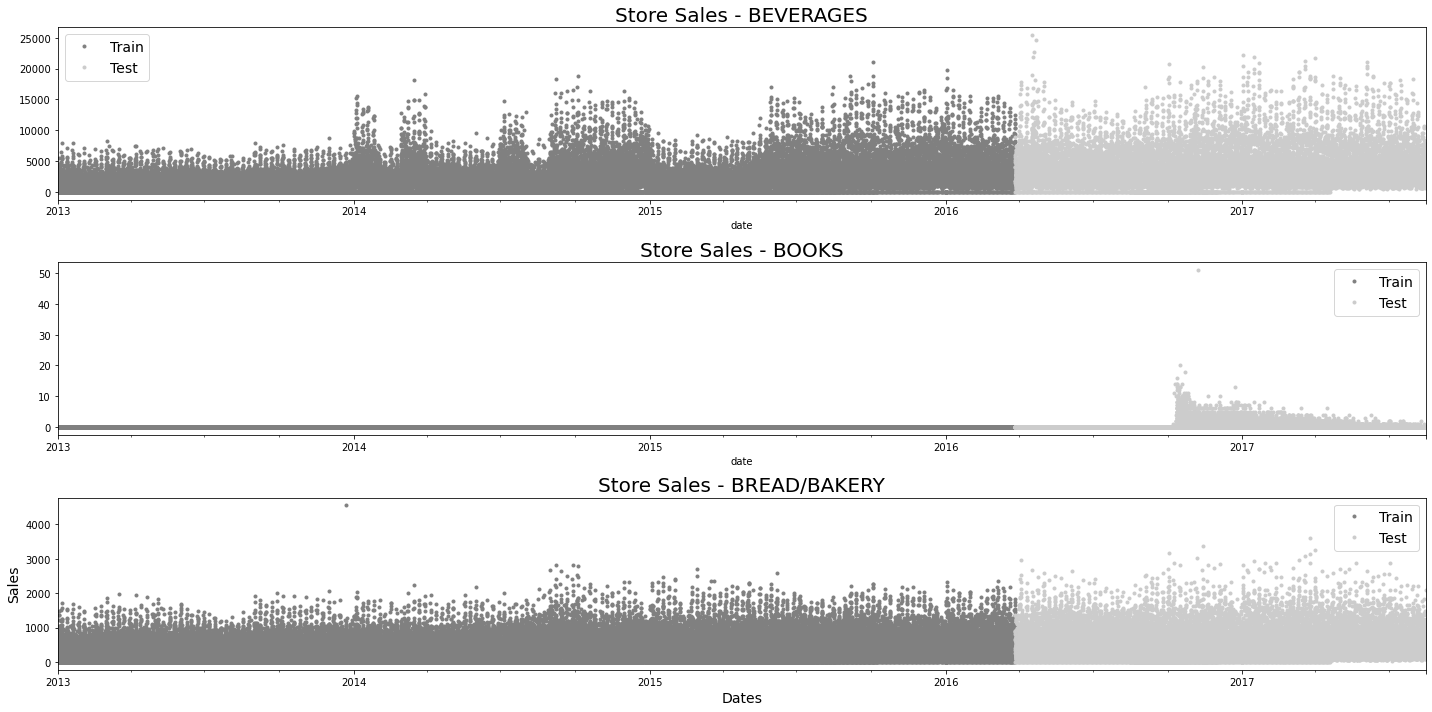

In [14]:
mul_plots('BEVERAGES', 'BOOKS', 'BREAD/BAKERY')

# 3. Apply ML models

### 1) Trend

In [14]:
# Fit data to trend model
def trend(ourtrain, ourtest, error):  

    # Modify data format
    train = ourtrain[['date', 'sales']].set_index("date").to_period("D")
    test = ourtest[['date', 'sales']].set_index("date").to_period("D")

    # Targets
    y_train = ext_targets(train)
    y_test = ext_targets(test)
    
    # Create features
    trend_dp = DeterministicProcess(
    index=train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
    )

    # `in_sample` creates features for the dates given in the `index` argument
    X_train = trend_dp.in_sample()

    # Fit model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pre = pd.Series(model.predict(X_train), index=X_train.index)

    # Out of Sample 
    X_oos = trend_dp.out_of_sample(steps=len(test.index))
    y_fore = pd.Series(model.predict(X_oos), index=X_oos.index)

    # # Plot
    # ax = train[:].plot(figsize=(20,10), linewidth=0.5, marker="o", markersize=2, color="0.5")
    # ax = y_pre[:].plot(ax=ax, linewidth=3, label="Trend")
    # ax = test[:].plot(ax=ax, linewidth=0.5, marker="o", markersize=2, color="0.8")
    # ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")

    # ax.set_title("Store Sales - Linear Trend Forecast", fontsize=20)
    # trendlabels = ['Actual Sales in Train', 'Trend', 'Actual Sales in Test', 'Trend Forecast']
    # _ = ax.legend(labels=trendlabels, prop={'size': 14})
    # _ = plt.xlabel("Id", size=14)
    # _ = plt.ylabel("Sales", size=14)

    return error(y_fore, y_test)


In [15]:
# Compute errors of all subsets
trend_errors = []
for key in family_list:
    ourtrain, ourtest = split_train(subsets[key])
    trend_errors.append(trend(ourtrain, ourtest, error))

In [16]:
print("Total Error from Trend model: ", round(sum(trend_errors), 4))

Total Error from Trend model:  39.6358


### 2) Periodogram

In [17]:
# Make "date" as index
def by_date(key):
    df= subsets[key].groupby(by="date").sum()
    df = pd.DataFrame(df['sales'])
    df = df.to_period('D')

    return df

# Generate a dictionary of "date"-indexed subsets
d_subsets = {}

for family in family_list:
    d_subsets.update({family:by_date(family)})

In [18]:
# Add seasonal features(day, week, dayofyear, year)
def add_seasonal(key):
    seasonal = d_subsets[key]
    seasonal["day"] = seasonal.index.dayofweek
    seasonal["week"] = seasonal.index.week
    seasonal["dayofyear"] = seasonal.index.dayofyear
    seasonal["year"] = seasonal.index.year
    return seasonal

for family in family_list:
    add_seasonal(family)

In [19]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.xaxis.set_tick_params(width=3)   # added to make the ticks thicker
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram", fontsize=15)  # added to set title size at 15
    ax.figure.set_size_inches(15, 8)    # added to adjust plot size
    return ax

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

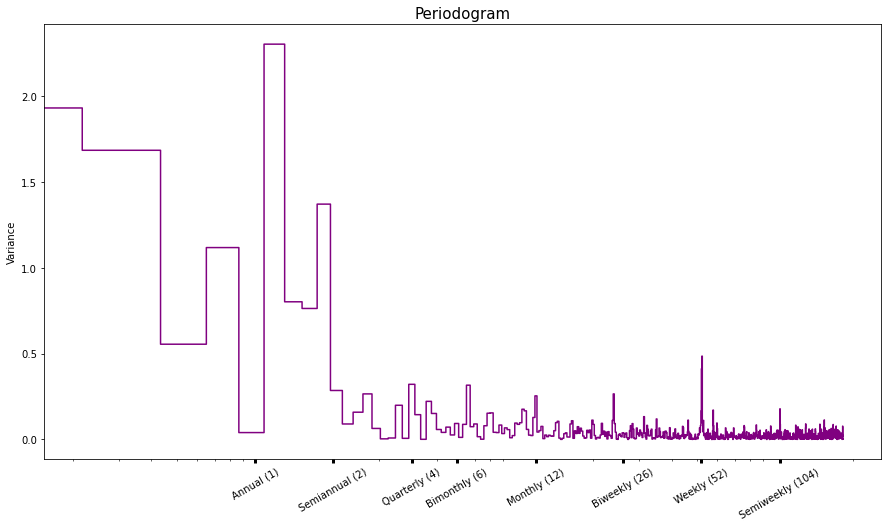

In [21]:
plot_periodogram(add_seasonal('BABY CARE').sales)   # Drops after Monthly

In [22]:
def seasonal(ourtrain, ourtest, error):

    y_test = ourtest['sales']

    # Use 12 pairs; 
    # From left to right, the periodogram drops off after Monthly(12)
    fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

    season_dp = DeterministicProcess(
        index=ourtrain.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    X = season_dp.in_sample()  # create features for dates in ourtrain.index
    y = ourtrain["sales"]

    season_model = LinearRegression(fit_intercept=False)
    _ = season_model.fit(X, y)

    # # sales values computed from season_model
    # y_season_pred = pd.Series(season_model.predict(X), index=y.index) 

    # Forecasting next 506 days of sales
    X_fore = season_dp.out_of_sample(steps=len(y_test.index))
    y_fore = pd.Series(season_model.predict(X_fore), index=X_fore.index)

    return error(y_fore, y_test)

In [23]:
# Compute errors of all subsets
seasonal_errors = []
for key in family_list:
    ourtrain, ourtest = split_train(add_seasonal(key))
    seasonal_errors.append(seasonal(ourtrain, ourtest, error))

In [24]:
print("Total Error from Seasonl model: ", round(sum(seasonal_errors), 4))

Total Error from Seasonl model:  17.5124


### 3) Cycles

In [25]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax
    

In [26]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

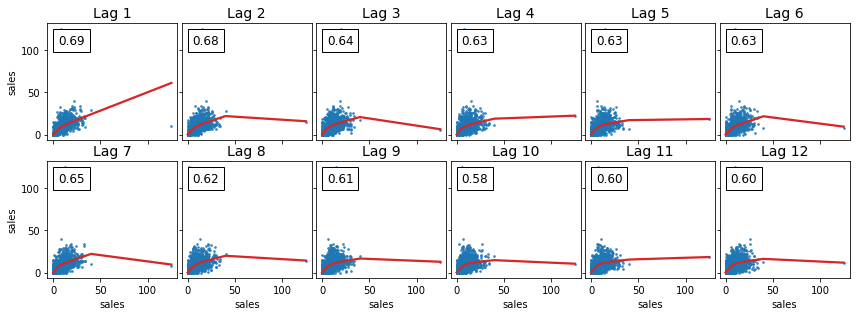

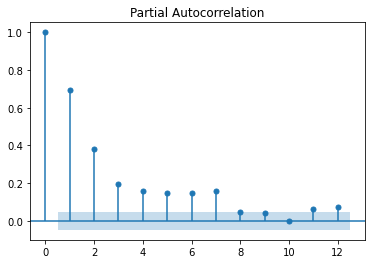

In [27]:
# Partial Autocorrelataion
from statsmodels.graphics.tsaplots import plot_pacf

plot_lags(add_seasonal('BABY CARE').sales, lags=12, nrows=2)
_ = plot_pacf(add_seasonal('BABY CARE').sales, lags=12)

In [28]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [29]:
def cycle(subset, error):
    
    X = make_lags(subset.sales, lags=7)
    X = X.fillna(0.0)
    y = subset.sales

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(len(X.index)*0.3), shuffle=False)

    ts_model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
    ts_model.fit(X_train, y_train)
    y_fore = pd.Series(ts_model.predict(X_test), index=X_test.index)
    y_fore[y_fore < 0] = 0

    return error(y_fore, y_test)

In [30]:
# Compute errors of all subsets
cycle_errors = []

for key in family_list:
    cycle_errors.append(cycle(subsets[key], error))

In [31]:
print("Error using Time Series as Features: ", round(sum(cycle_errors), 4))

Error using Time Series as Features:  34.4347


### 4) Hybrid _ Direct Strategy

In [34]:
from xgboost import XGBRegressor

def hybrid(ourtrain, ourtest, error):

    # Modify data format
    train = ourtrain[['date', 'sales']].set_index("date").to_period("D")
    test = ourtest[['date', 'sales']].set_index("date").to_period("D")

    # Targets
    y_train = ext_targets(train)
    y_test = ext_targets(test)
    
    # Create features
    hybrid_dp = DeterministicProcess(
        index=train.index,  # dates from the training data
        constant=True,       # dummy feature for the bias (y_intercept)
        order=2,             # the time dummy (trend)
        drop=True,           # drop terms if necessary to avoid collinearity
    )

    # `in_sample` creates features for the dates given in the `index` argument
    X_train = hybrid_dp.in_sample()

    # Fit model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pre = pd.Series(model.predict(X_train), index=X_train.index)  # predicted value using in-sample(train)

    # Out of Sample 
    X_oos = hybrid_dp.out_of_sample(steps=len(test.index))
    y_fore = pd.Series(model.predict(X_oos), index=X_oos.index)     # predicted value using out-sample(test)


    X_test = hybrid_dp.in_sample()


    # Create residuals (the collection of detrended series) from the training set
    y_resid = y_train - y_pre

    # Train XGBoost on the residuals
    xgb = XGBRegressor()
    xgb.fit(X_train, y_resid)

    # # Add the predicted residuals onto the predicted trends
    y_fore_boosted = xgb.predict(X_oos) + y_fore

    return error(y_fore_boosted, y_test)


In [35]:
# Compute errors of all subsets
hybrid_errors = []

for key in family_list:
    ourtrain, ourtest = split_train(subsets[key])
    hybrid_errors.append(hybrid(ourtrain, ourtest, error))

In [36]:
print("Total Error from hybrid model: ", round(sum(hybrid_errors), 4))

Total Error from hybrid model:  50.745


# 4. Choose the ML model which gives the min error

In [37]:
# Compare
print("Total Error from Trend model: ", round(sum(trend_errors), 4))
print("Total Error from Seasonl model: ", round(sum(seasonal_errors), 4))
print("Error using Time Series as Features: ", round(sum(cycle_errors), 4))
print("Total Error from hybrid model: ", round(sum(hybrid_errors), 4))

Total Error from Trend model:  39.6358
Total Error from Seasonl model:  17.5124
Error using Time Series as Features:  34.4347
Total Error from hybrid model:  50.745


### - Trim test dataset

In [38]:
# Check unique values of "family"
test_family_list = test["family"].unique()
print(test_family_list, "\nNumber of unique values:", len(test_family_list))

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD'] 
Number of unique values: 33


In [39]:
# Save the subsets in dictionary
test_subsets = {}
for family in test_family_list:
    test_subsets.update({family:generate_subsets(family)})

In [49]:
# Modify function
def seasonal_final(train, test):

    fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

    season_dp = DeterministicProcess(
        index=train.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    X = season_dp.in_sample()  # create features for dates in train.index
    y = train["sales"]

    season_model = LinearRegression(fit_intercept=False)
    _ = season_model.fit(X, y)

    # Forecasting sales
    X_fore = season_dp.out_of_sample(steps=len(test.index))
    y_fore = pd.Series(season_model.predict(X_fore), index=X_fore.index)

    return y_fore

In [50]:
forecasting = []

# Apply seasonal model
for key in test_family_list:
    forecasting.append(seasonal_final(subsets[key], test_subsets[key]))


AttributeError: 'NoneType' object has no attribute 'rule_code'

In [ ]:
forecasting